In [1]:
import importlib
from pathlib import Path
import itertools
import pickle

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

from scipy.stats import pearsonr, spearmanr
import scipy.stats
from statsmodels import api as sm
import pyBigWig
import logomaker
import json

from Modules import utils, plot_utils

In [2]:
importlib.reload(utils)
importlib.reload(plot_utils)
data_dir = '../shared_folder'
writing_dir = '../shared_folder'
# writing_dir='../'
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
def mywho():
    np.who({k: v for k, v in globals().items() if k[0]!= '_'})

In [3]:
species = 'SCerevisiae'

Load one_hot genomes

In [4]:
with np.load(Path(data_dir, species, 'genome', 'W303_Mmmyco.npz')) as f:
    one_hots_myco = {k: f[k] for k in f.keys()}
with np.load(Path(data_dir, species, 'genome', 'S288c_Mpneumo.npz')) as f:
    one_hots_pneu = {k: f[k] for k in f.keys() if k != 'Mito'}

Load labels

In [100]:
with np.load(Path(data_dir, species, 'data', 'GSE217022', 'labels_myco_coh.npz')) as f:
    myco_coh = {k: f[k] for k in f.keys()}
with np.load(Path(data_dir, species, 'data', 'GSE217022', 'labels_myco_pol.npz')) as f:
    myco_pol = {k: f[k] for k in f.keys()}
with np.load(Path(data_dir, species, 'data', 'GSE217022', 'labels_pneu_coh.npz')) as f:
    pneu_coh = {k: f[k] for k in f.keys()}
with np.load(Path(data_dir, species, 'data', 'GSE217022', 'labels_pneu_pol.npz')) as f:
    pneu_pol = {k: f[k] for k in f.keys()}

with np.load(Path(data_dir, species, 'data', 'GSE217022', 'labels_myco_coh_KL.npz')) as f:
    myco_coh_KL = {k: f[k] for k in f.keys()}
with np.load(Path(data_dir, species, 'data', 'GSE217022', 'labels_myco_pol_KL.npz')) as f:
    myco_pol_KL = {k: f[k] for k in f.keys()}
with np.load(Path(data_dir, species, 'data', 'GSE217022', 'labels_pneu_coh_KL.npz')) as f:
    pneu_coh_KL = {k: f[k] for k in f.keys()}
with np.load(Path(data_dir, species, 'data', 'GSE217022', 'labels_pneu_pol_KL.npz')) as f:
    pneu_pol_KL = {k: f[k] for k in f.keys()}

lens = {'myco': {k: len(v) for k, v in myco_coh.items()},
        'pneu': {k: len(v) for k, v in pneu_coh.items()}}

In [102]:
utils.write_bw(Path(data_dir, species, 'data', 'GSE217022', 'labels_myco_coh_KL.bw'), myco_coh_KL)
utils.write_bw(Path(data_dir, species, 'data', 'GSE217022', 'labels_myco_pol_KL.bw'), myco_pol_KL)
utils.write_bw(Path(data_dir, species, 'data', 'GSE217022', 'labels_pneu_coh_KL.bw'), pneu_coh_KL)
utils.write_bw(Path(data_dir, species, 'data', 'GSE217022', 'labels_pneu_pol_KL.bw'), pneu_pol_KL)

In [9]:
mnase_myco = utils.load_bw(Path(data_dir, species, 'data', 'mnase_myco.bw'))
mnase_pneumo = utils.load_bw(Path(data_dir, species, 'data', 'mnase_pneumo.bw'))
scc1_myco = utils.load_bw(Path(data_dir, species, 'data', 'scc1_myco.bw'))
scc1_pneumo = utils.load_bw(Path(data_dir, species, 'data', 'scc1_pneumo.bw'))
pol2_myco = utils.load_bw(Path(data_dir, species, 'data', 'pol2_myco.bw'))
pol2_pneumo = utils.load_bw(Path(data_dir, species, 'data', 'pol2_pneumo.bw'))

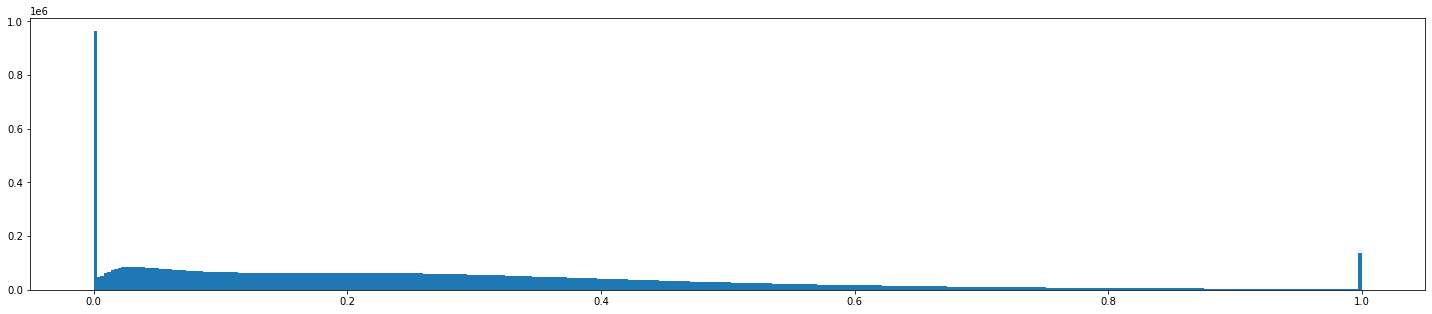

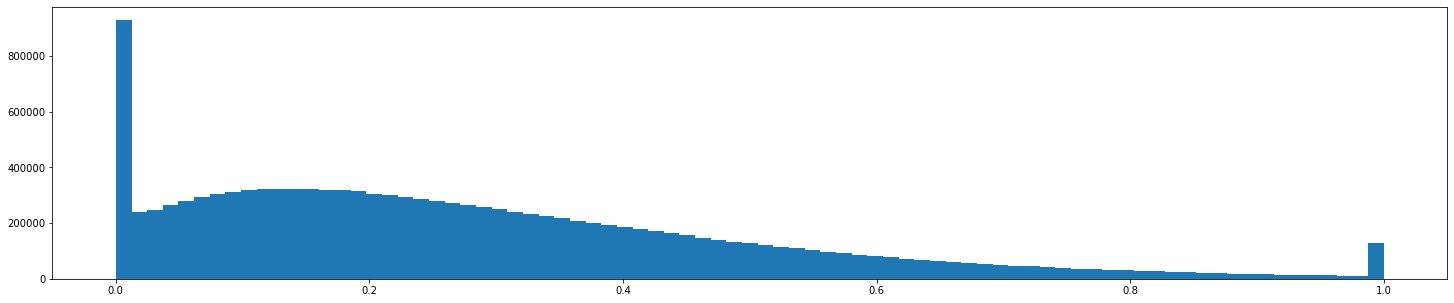

In [126]:
mergem = np.concatenate(list(myco_nuc.values()))
plt.figure(figsize=(25, 5))
plt.hist(mergem, bins=370, range=(0, 1))
plt.show()

mergep = np.concatenate(list(pneu_nuc.values()))
plt.figure(figsize=(25, 5))
plt.hist(mergep, bins=81, range=(0, 1))
plt.show()

In [127]:
uniq, counts = np.unique(mergep, return_counts=True)
len(uniq)

81

In [128]:
def clipnorm(signals, q=0.99):
    """Clip max signal to a given quantile and normalize between 0 and 1."""
    full = np.concatenate(list(signals.values()))
    quant = np.quantile(full, q)
    return {k: np.clip(v, None, quant) / quant for k, v in signals.items()}

mnase_myco = utils.load_bw(Path(data_dir, species, 'data', 'mnase_myco.bw'))
mnase_pneumo = utils.load_bw(Path(data_dir, species, 'data', 'mnase_pneumo.bw'))

myco_nuc = clipnorm(mnase_myco)
pneu_nuc = clipnorm({k: v for k, v in mnase_pneumo.items() if k!='Mito'})

np.savez_compressed(Path(data_dir, species, 'data', 'labels_myco_nuc.npz'), **myco_nuc)
np.savez_compressed(Path(data_dir, species, 'data', 'labels_pneu_nuc.npz'), **pneu_nuc)

In [38]:
myco_coh_ip = utils.load_bw(Path(data_dir, species, 'data', 'GSE217022', 'GSM6703630_Scc1_Mmyco_rep1.CPM.bw'), 'W303')
myco_coh_ctrl = utils.load_bw(Path(data_dir, species, 'data', 'GSE217022', 'GSM6703631_Scc1-inp_Mmyco_rep1.CPM.bw'), 'W303')
pneu_coh_ip = utils.load_bw(Path(data_dir, species, 'data', 'GSE217022', 'GSM6703640_Scc1_Mpneumo_rep1.CPM.bw'), 'S288c')
pneu_coh_ctrl = utils.load_bw(Path(data_dir, species, 'data', 'GSE217022', 'GSM6703641_Scc1-inp_Mpneumo_rep1.CPM.bw'), 'S288c')

myco_pol_ip = utils.load_bw(Path(data_dir, species, 'data', 'GSE217022', 'GSM6703624_PolII_Mmyco_rep1.CPM.bw'), 'W303')
myco_pol_ctrl = utils.load_bw(Path(data_dir, species, 'data', 'GSE217022', 'GSM6703625_PolII-inp_Mmyco_rep1.CPM.bw'), 'W303')
myco_pol_ip2 = utils.load_bw(Path(data_dir, species, 'data', 'GSE217022', 'GSM6703626_PolII_Mmyco_rep2.CPM.bw'), 'W303')
myco_pol_ctrl2 = utils.load_bw(Path(data_dir, species, 'data', 'GSE217022', 'GSM6703627_PolII-inp_Mmyco_rep2.CPM.bw'), 'W303')
pneu_pol_ip = utils.load_bw(Path(data_dir, species, 'data', 'GSE217022', 'GSM6703638_PolII_Mpneumo_rep1.CPM.bw'), 'S288c')
pneu_pol_ctrl = utils.load_bw(Path(data_dir, species, 'data', 'GSE217022', 'GSM6703639_PolII-inp_Mpneumo_rep1.CPM.bw'), 'S288c')

In [104]:
for signals in [myco_coh_ip, myco_coh_ctrl, pneu_coh_ip, pneu_coh_ctrl,
                myco_pol_ip, myco_pol_ctrl, myco_pol_ip2, myco_pol_ctrl2, pneu_pol_ip, pneu_pol_ctrl]:
    print(np.sum(np.concatenate(list(signals.values()))))

313678300.0
277992130.0
338243400.0
278769860.0
269219300.0
254790460.0
273671870.0
266927330.0
219618610.0
165207140.0


In [27]:
myco_nuc = utils.load_bw('/home/alex/shared_folder/SCerevisiae/data/GSE217022/GSM6703666_MNase_Mmyco_rep1.130-200.CPM.bw', 'W303')
pneu_nuc = utils.load_bw('/home/alex/shared_folder/SCerevisiae/data/GSE217022/GSM6703668_MNase_Mpneumo_rep1.130-200.CPM.bw', 'S288c')
myco_nuc2 = utils.load_bw('/home/alex/shared_folder/SCerevisiae/data/GSE217022/GSM6703667_MNase_Mmyco_rep2.130-200.CPM.bw', 'W303')
pneu_nuc2 = utils.load_bw('/home/alex/shared_folder/SCerevisiae/data/GSE217022/GSM6703669_MNase_Mpneumo_rep2.130-200.CPM.bw', 'S288c')

In [19]:
for key, value in mnase_myco.items():
    print(key, pearsonr(value, myco_nuc[key])[0], pearsonr(value, myco_nuc2[key])[0])

chrI 0.4833832948127207 0.47979945248019373
chrII 0.41162995461239577 0.40896180444424746
chrIII 0.5051386728787928 0.5057406278186105
chrIV 0.4474446071239533 0.44579702681810807
chrV 0.4447667112449227 0.44701402361950576
chrVI 0.4298766662499847 0.42698150517421324
chrVII 0.4154955803734845 0.4121405971826473
chrVIII 0.46244756399795106 0.4637535720245949
chrIX 0.43186073473945985 0.4316391327889334
chrX 0.4466040021967912 0.4452018984006805
chrXI 0.3842043750058234 0.38406305183193934
chrXII 0.01933985757622729 0.4790328398735542
chrXIII 0.4127447978642644 0.41244621467082226
chrXIV 0.4185861477336549 0.41498690031526153
chrXV 0.40973230338496897 0.4099868876650792
chrXVI 0.4086831962549946 0.405564042452913
Mmmyco 0.3796140597429791 0.4005232774499113


In [ ]:
model_name = 'model_myco_pol_3_batch'
with np.load(Path(data_dir, 'SCerevisiae', 'results', model_name, 'preds_on_W303_Mmmyco.npz')) as fm:

with np.load(Path(data_dir, 'SCerevisiae', 'results', model_name, 'preds_on_S288c_Mpneumo.npz')) as fp:

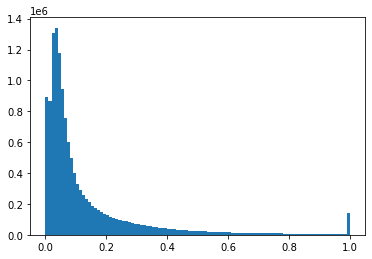

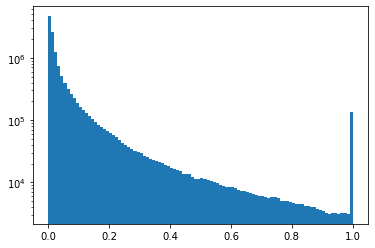

In [6]:
full = np.concatenate(list(myco_coh.values()))
plt.hist(full, bins=100)
plt.show()

full = np.concatenate(list(myco_coh_KL.values()))
plt.hist(full, bins=100)
plt.yscale('log')
plt.show()

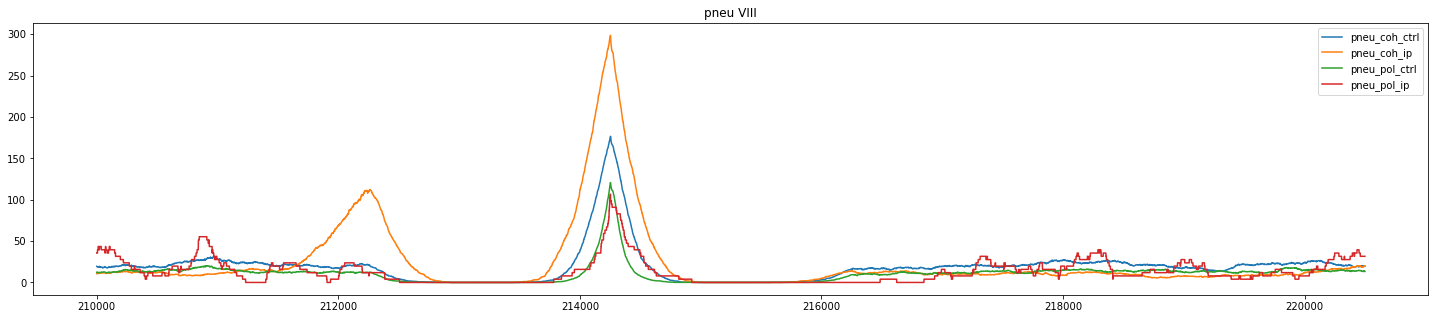

In [99]:
strand = 'pneu' # 'myco' #
chr_id = 'VIII'
start = 210_000
stop = 220_500 # start + 100_000

fig, ax = plt.subplots(1, 1, figsize=(25, 5), facecolor='w')
if strand == 'myco' and chr_id != 'Mmmyco':
    chr_id = 'chr' + chr_id
stop = min(stop, lens[strand][chr_id])

plt.title(f'{strand} {chr_id}')
# ax.plot(np.arange(start, stop), pneu_coh_KL[chr_id][start:stop], label='pneu_coh')
# ax.plot(np.arange(start, stop), pneu_coh[chr_id][start:stop], label='pneu_coh')
# ax.plot(np.arange(start, stop), myco_pol[chr_id][start:stop], label='myco_pol')
# ax.plot(np.arange(start, stop), myco_pol_KL[chr_id][start:stop], label='myco_pol_KL')

# ax.plot(np.arange(start, stop), mnase_myco[chr_id][start:stop], label='mnase_myco')

# ax.plot(np.arange(start, stop), mnase_pneumo[chr_id][start:stop], label='mnase_pneumo')

# ax.plot(np.arange(start, stop), scc1_pneumo[chr_id][start:stop], label='scc1_pneumo')
# ax.set_ylim(bottom=-0.2)
# ax2 = ax.twinx()
# ax2.plot(np.arange(start, stop), pneu_coh_ip[chr_id][start:stop] * np.log2(1 + pneu_coh_ip[chr_id][start:stop] / pneu_coh_ctrl[chr_id][start:stop]), label='pneu_coh_ip')
# ax3 = ax.twinx()
# ax2.plot(np.arange(start, stop), pneu_coh_ip[chr_id][start:stop] * np.log(1 + pneu_coh_ip[chr_id][start:stop] / pneu_coh_ctrl[chr_id][start:stop]), label='pneu_coh_ip', alpha=0.5, color=colors[1])
# ax3.plot(np.arange(start, stop), pneu_coh_KL[chr_id][start:stop], label='pneu_coh_KL', color='k', alpha=0.5)
ax.legend()

In [69]:
for chr_id, signal in mnase_pneumo.items():
    print(chr_id, np.min(signal), np.max(signal))

I 0.0 154.0
II 0.0 149.0
III 0.0 137.0
IV 0.0 147.0
V 0.0 142.0
VI 0.0 133.0
VII 0.0 162.0
VIII 0.0 158.0
IX 0.0 148.0
X 0.0 153.0
XI 0.0 159.0
XII 0.0 151.0
XIII 0.0 147.0
XIV 0.0 143.0
XV 0.0 161.0
XVI 0.0 169.0
Mpneumo 0.0 144.0


Compute GC content

In [42]:
gc_W303 = utils.GC_content(np.expand_dims(np.concatenate([v for k, v in one_hots_myco.items() if k!='Mmmyco']), axis=0))
gc_S288c = utils.GC_content(np.expand_dims(np.concatenate([v for k, v in one_hots_pneu.items() if k!='Mpneumo']), axis=0))
gc_myco = utils.GC_content(np.expand_dims(one_hots_myco['Mmmyco'], axis=0))
gc_pneu = utils.GC_content(np.expand_dims(one_hots_pneu['Mpneumo'], axis=0))    
print(gc_W303, gc_S288c, gc_myco, gc_pneu)

[0.38334965] [0.38297367] [0.24156089] [0.40010954]
